In [121]:
import pandas as pd
import numpy as np
import glob
# display all the columns
pd.options.display.max_columns = None
from functools import reduce
import datetime as dt
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt   #Data visualisation libraries 
import pickle
from xgboost import XGBClassifier
from xgboost import XGBRegressor 
from matplotlib import pyplot
from xgboost import plot_importance
import os 

import altair as alt
#alt.renderers.enable('notebook')
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [122]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

## Get  data

In [125]:
path = r"C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive"
path_excel = r"C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\New Data Set"

pickle_in = open(os.path.join(path, "df_data_combined_M1_M2_MD.pickle"),"rb")
df = pickle.load(pickle_in)

#pickle_in = open(os.path.join(path, "df_SOP.pickle"),"rb")
#df_SOP = pickle.load(pickle_in)
df_SOP = pd.read_excel(r'C:\Users\BE106641\Documents\Data Science\Git\Sales-Auto\Copy of Book1.xlsx',sheet_name = 'Sheet7')

df_human_fct = pd.read_excel(r'C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\New Data Set\forecast 2018 - Copy.xlsx')

df_human_fct.columns = df_human_fct.columns.str.lower()
df_human_fct = df_human_fct.rename(columns=lambda x: x.replace('\n', ' ').strip())
df_human_fct = df_human_fct[df_human_fct['market']==2]

#df_SOP.columns = df_SOP.columns.str.lower()
#df_SOP = df_SOP.rename(columns=lambda x: x.replace('\n', ' ').strip())
df_human_fct

product  market  qty fct h 2018  qty fct h 2019  qty fct h 2020  \
12    6300077       2            2048            2280            1140   
13    6300078       2            2048            2280            1140   
107   6904235       2               0               0               0   
108   6904237       2               0               0               0   
109   6903106       2               0               0               0   
...       ...     ...             ...             ...             ...   
7056  6901701       2             278             240             240   
7057  6902593       2              21              30              30   
7058  6901700       2              91              30              30   
7059  6902592       2              36              30              30   
7060  6901699       2              91              30              30   

      qty fct h 2021  
12                 0  
13                 0  
107                0  
108                0  
109                0  
...              ...  
7056             240  
7057              30  
7058              30  
7059              30  
7060              30  

[3476 rows x 6 columns]

##### merge historical data (2007 - 2018) with sales from 2019

In [126]:
df.shape

(3928, 41)

In [127]:
#df.to_excel(r'C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\df_combined_2703.xlsx')

In [128]:
df_human_fct.drop(columns = ["market"],axis = 1, inplace = True)

In [129]:
df_human_fct = df_human_fct.groupby(['product'],as_index = False).sum()

In [130]:
df_human_fct

product  qty fct h 2018  qty fct h 2019  qty fct h 2020  qty fct h 2021
0     6300001               0               0               0               0
1     6300002             131             150              75              75
2     6300003             258             120              80              80
3     6300004             316             250             150             150
4     6300005             271             150             100             100
...       ...             ...             ...             ...             ...
3152  6999030              18              30              30              30
3153  6999035              18              30              30              30
3154  6999094              68              70               0               0
3155  6999095              43              70               0               0
3156  6999512               1               1               0               0

[3157 rows x 5 columns]

In [291]:
df_combined = pd.merge(df, df_SOP,  how='left', on=['product'])
df_combined['SOP'] = df_combined['SOP'].dt.year 
df_combined.shape

(3928, 42)

In [292]:
#df_combined = df_combined_SOP.copy()

In [293]:
df_combined.iloc[:,13:] = df_combined.iloc[:,13:].fillna(0)

In [294]:
df_combined.shape

(3928, 42)

In [295]:
df_combined[df_combined['SOP']==0]

product                        product description  market  \
0     6960311.0                  W/S X KR 250 HT CLA L NSE     2.0   
1     6960312.0                  FFX X KR 250 HT CLA L NSE     2.0   
2     6991779.0                  F/D X KR 250 HT CLA T NSE     2.0   
3     6991780.0                  FVT X KR 250 HT CLA T NSE     2.0   
4     6991781.0              B/L X KR 250 HT CLA T NHT NSE     2.0   
...         ...                                        ...     ...   
3637  6904806.0              R/D L FO FI5 H5 GYU T 001 STC     2.0   
3645  6970264.0          W/S L OP 36X H5 GNV L APP CAM PRI     2.0   
3655  6969883.0  W/S X AU 37X H3 GNV L ACO CAM HDW RSB SSC     2.0   
3751  6903439.0              R/D L VZ 110 4D GNV T HFR NSE     2.0   
3753  6903438.0              R/D R VZ 110 4D GNV T HFR NSE     2.0   

      tier level family sub family commercial family brand    brand group  \
0            0.0    WSC        WNH               WSC    KR  LOCAL RUSSIAN   
1            0.0    SID        SLN               SLL    KR  LOCAL RUSSIAN   
2            0.0    SID        SNH               S/L    KR  LOCAL RUSSIAN   
3            0.0    SID        SNH               S/L    KR  LOCAL RUSSIAN   
4            0.0    BCK        BNH               B/L    KR  LOCAL RUSSIAN   
...          ...    ...        ...               ...   ...            ...   
3637         0.0    SID        SNH               S/L    FO           FORD   
3645         0.0    WSC        WNH               WSC    OP            PSA   
3655         0.0    WSC        WNH               WSC    AU            VAG   
3751         1.0    SID        SNH                SL   LAD            VAZ   
3753         1.0    SID        SNH                SL   LAD            VAZ   

     gkam model body risk  qty total M1 2007  qty total M1 2008  \
0     G14   250   HT   S1             3911.0             2600.0   
1     G14   250   HT   S1             5368.0             4590.0   
2     G14   250   HT   S1                0.0                0.0   
3     G14   250   HT   S1                0.0                0.0   
4     G14   250   HT   S1                0.0                0.0   
...   ...   ...  ...  ...                ...                ...   
3637  G11   FI5   H5   S1                0.0                0.0   
3645  G01   36X   H5   S1                0.0                0.0   
3655  G03   37X   H3   S1                0.0                0.0   
3751  G02   110   S4   S1                0.0                0.0   
3753  G02   110   S4   S1                0.0                0.0   

      qty total M1 2009  qty total M1 2010  qty total M1 2011  \
0                 250.0                0.0                0.0   
1                 200.0                0.0                0.0   
2                   0.0                0.0                0.0   
3                   0.0                0.0                0.0   
4                   0.0                0.0                0.0   
...                 ...                ...                ...   
3637                0.0                0.0                0.0   
3645                0.0                0.0                0.0   
3655                0.0                0.0                0.0   
3751                0.0                0.0                0.0   
3753                0.0                0.0                0.0   

      qty total M1 2012  qty total M1 2013  qty total M1 2014  \
0                   0.0                0.0                0.0   
1                   0.0                0.0                0.0   
2                   0.0                0.0                0.0   
3                   0.0                0.0                0.0   
4                   0.0                0.0                0.0   
...                 ...                ...                ...   
3637                0.0                0.0                0.0   
3645                0.0                0.0                0.0   
3655                0.0                0.0                0.0   
3751  

# 1. Feature Analysis

In [296]:
#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'
df_combined.loc[df_combined['qty total M2 2013']>0, 'flag_2013'] = 1
df_combined.loc[df_combined['qty total M2 2014']>0, 'flag_2014'] = 1
df_combined.loc[df_combined['qty total M2 2015']>0, 'flag_2015'] = 1
df_combined.loc[df_combined['qty total M2 2016']>0, 'flag_2016'] = 1
df_combined.loc[df_combined['qty total M2 2017']>0, 'flag_2017'] = 1
df_combined.loc[df_combined['qty total M2 2018']>0, 'flag_2018'] = 1
df_combined.loc[df_combined['qty total M2 2013']<=0, 'flag_2013'] = 0
df_combined.loc[df_combined['qty total M2 2014']<=0, 'flag_2014'] = 0
df_combined.loc[df_combined['qty total M2 2015']<=0, 'flag_2015'] = 0
df_combined.loc[df_combined['qty total M2 2016']<=0, 'flag_2016'] = 0
df_combined.loc[df_combined['qty total M2 2017']<=0, 'flag_2017'] = 0
df_combined.loc[df_combined['qty total M2 2018']<=0, 'flag_2018'] = 0

In [297]:
df_combined[df_combined.duplicated(keep=False)]

Empty DataFrame
Columns: [product, product description, market, tier level, family, sub family, commercial family, brand, brand group, gkam, model, body, risk, qty total M1 2007, qty total M1 2008, qty total M1 2009, qty total M1 2010, qty total M1 2011, qty total M1 2012, qty total M1 2013, qty total M1 2014, qty total M1 2015, qty total M1 2016, qty total M1 2017, qty total M1 2018, qty total M1 2019, qty total M2 2007, qty total M2 2008, qty total M2 2009, qty total M2 2010, qty total M2 2011, qty total M2 2012, qty total M2 2013, qty total M2 2014, qty total M2 2015, qty total M2 2016, qty total M2 2017, qty total M2 2018, qty total M2 2019, qty total M1, qty total M2, SOP, flag_2013, flag_2014, flag_2015, flag_2016, flag_2017, flag_2018]
Index: []

In [298]:
df_combined['flag_tot'] = df_combined['flag_2013'] + df_combined['flag_2014'] + df_combined['flag_2015'] + df_combined['flag_2016'] + df_combined['flag_2017'] + df_combined['flag_2018'] 

In [299]:
#df_combined = df_combined[(df_combined['flag_tot']<=3)] #&(df_combined['qty total M2 2018']>0)]

In [300]:
#df_combined = df_combined[(df_combined['qty total M2 2014']>0) & (df_combined['qty total M2 2015']>0) & (df_combined['qty total M2 2016']>0)& (df_combined['qty total M2 2013']>0)]

In [301]:
df_combined.shape

(3928, 49)

In [302]:
df_combined.drop(columns = ['flag_tot','flag_2013','flag_2014','flag_2015','flag_2016','flag_2017','flag_2018'],inplace = True)

In [319]:
X_2018 = df_combined.drop(columns = ['qty total M2 2019','qty total M1 2019','product','product description','sub family','qty total M1','qty total M2'])
y_2018 = df_combined[['qty total M2 2018']]
#X.drop(columns = ['id1','country','id2','product','product description','dest1','dest3','tier level','destination description'], inplace = True)
X_2018.drop(X_2018[['model','risk']],axis = 1, inplace = True)

In [320]:
X = df_combined.drop(columns = ['qty total M2 2018','qty total M1 2018','qty total M2 2019','qty total M1 2019','product','product description','sub family','qty total M1','qty total M2'])
y = df_combined[['qty total M2 2017']]
#X.drop(columns = ['id1','country','id2','product','product description','dest1','dest3','tier level','destination description'], inplace = True)
X.drop(X[['model','risk']],axis = 1, inplace = True)

In [304]:
column_list = X.columns[0:9]
column_list

Index(['market', 'tier level', 'family', 'commercial family', 'brand',
       'brand group', 'gkam', 'body', 'qty total M1 2007'],
      dtype='object')

In [321]:
for column in column_list:
    X[column] = X[column].astype('category')
    X[column] = X[column].cat.codes

In [306]:
X.head(5)

market  tier level  family  commercial family  brand  brand group  gkam  \
0       0           0       2                 11     17           13    12   
1       0           0       1                  8     17           13    12   
2       0           0       1                  6     17           13    12   
3       0           0       1                  6     17           13    12   
4       0           0       0                  0     17           13    12   

   body  qty total M1 2007  qty total M1 2008  qty total M1 2009  \
0    11                260             2600.0              250.0   
1    11                296             4590.0              200.0   
2    11                  0                0.0                0.0   
3    11                  0                0.0                0.0   
4    11                  0                0.0                0.0   

   qty total M1 2010  qty total M1 2011  qty total M1 2012  qty total M1 2013  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   qty total M1 2014  qty total M1 2015  qty total M1 2016  qty total M1 2017  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   qty total M1 2018  qty total M2 2007  qty total M2 2008  qty total M2 2009  \
0                0.0             3424.0             2400.0              150.0   
1                0.0             1200.0              400.0                0.0   
2                0.0             5725.0              405.0              400.0   
3                0.0             5490.0             1205.0              400.0   
4                0.0             2655.0              510.0              200.0   

   qty total M2 2010  qty total M2 2011  qty total M2 2012  qty total M2 2013  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   qty total M2 2014  qty total M2 2015  qty total M2 2016  qty total M2 2017  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                0.0                0.0                0.0   

   qty total M2 2018  SOP  
0                0.0  0.0  
1                0.0  0.0  
2                0.0  0.0  
3                0.0  0.0  
4                0.0  0.0

In [307]:
X['qty total 2007 - 2009 M1']= X[['qty total M1 2007','qty total M1 2008','qty total M1 2009']].sum(axis=1)
X['qty total 2007 - 2009 M2']= X[['qty total M2 2007','qty total M2 2008','qty total M2 2009']].sum(axis=1)
X['qty total 2010 - 2012 M1']= X[['qty total M1 2010','qty total M1 2011','qty total M1 2012']].sum(axis=1)
X['qty total 2010 - 2012 M2']= X[['qty total M2 2010','qty total M2 2011','qty total M2 2012']].sum(axis=1)

In [308]:
X.drop(X[['qty total M1 2007','qty total M1 2008','qty total M1 2009']],axis = 1, inplace = True)
X.drop(X[['qty total M2 2007','qty total M2 2008','qty total M2 2009']],axis = 1, inplace = True)
X.drop(X[['qty total M1 2010','qty total M1 2011','qty total M1 2012']],axis = 1, inplace = True)
X.drop(X[['qty total M2 2010','qty total M2 2011','qty total M2 2012']],axis = 1, inplace = True)

#### remove features with low importance

In [309]:
# fit model no training data
model = XGBRegressor()
model.fit(X, y)

# feature importance
print(model.feature_importances_)

[12:23:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.         0.         0.02159845 0.02783789 0.01130811 0.01322746
 0.01001584 0.01131699 0.02754    0.0170767  0.01748937 0.09950689
 0.00610439 0.02599885 0.00620846 0.0085571  0.01404613 0.00436674
 0.3174292  0.27555215 0.05875779 0.01404553 0.00404331 0.00492529
 0.0030473 ]


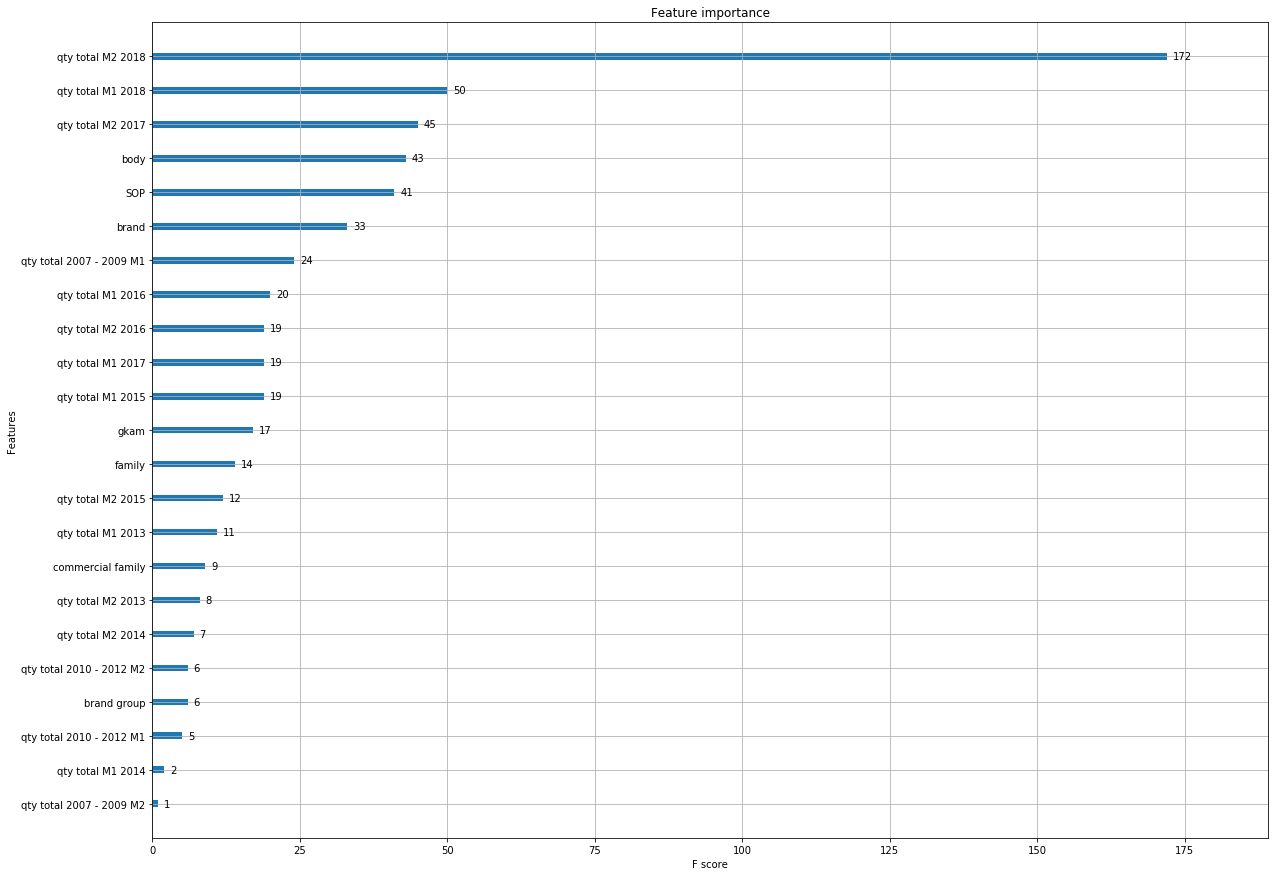

In [310]:
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20,15)

In [173]:
X

market  tier level  family  commercial family  brand  brand group  gkam  \
0          0           0       2                 11     30           12    12   
1          0           0       2                 11     30           12    12   
2          0           1       1                  6     42           20     2   
3          0           0       2                 10      3            0     6   
4          0           0       2                 11      3            0     6   
...      ...         ...     ...                ...    ...          ...   ...   
2978       0          -1       1                  7     38           19    -1   
2979       0          -1       1                  7     38           19    -1   
2980       0          -1       2                  3     38           19    -1   
2981       0          -1       2                  3     38           19    -1   
2982       0          -1       2                  3     38           19    -1   

      body  qty total M1 2013  qty total M1 2014  qty total M1 2015  \
0        3             1280.0                0.0                0.0   
1        3             1285.0               -1.0                0.0   
2       12                0.0                0.0                0.0   
3        2                0.0                0.0                0.0   
4        2                0.0                0.0                0.0   
...    ...                ...                ...                ...   
2978    20                0.0                0.0                0.0   
2979    20                0.0                0.0                0.0   
2980    20                0.0                0.0                0.0   
2981    20                0.0                0.0                0.0   
2982    20                0.0                0.0                0.0   

      qty total M1 2016  qty total M2 2013  qty total M2 2014  \
0                   0.0               75.0                0.0   
1                   0.0               75.0                0.0   
2                   0.0              800.0                0.0   
3                   0.0              172.0              218.0   
4                   0.0              264.0               88.0   
...                 ...                ...                ...   
2978                0.0                0.0                0.0   
2979                0.0                0.0                0.0   
2980                0.0                0.0                0.0   
2981                0.0                0.0                0.0   
2982                0.0                0.0                0.0   

      qty total M2 2015  qty total M2 2016   SOP  qty total 2007 - 2009 M1  \
0                   0.0                0.0  1989                    2324.0   
1                   0.0                0.0  1989                    1703.0   
2                   0.0                0.0  1997                       0.0   
3                 281.0              169.0  1995                       0.0   
4                 132.0               88.0  1995                       0.0   
...                 ...                ...   ...                       ...   
2978                0.0                0.0  2019                       0.0   
2979                0.0                0.0  2019                       0.0   
2980                0.0                0.0  2019                       0.0   
2981                0.0                0.0  2019                       0.0   
2982                0.0                0.0  2019                       0.0   

      qty total 2007 - 2009 M2  qty total 2010 - 2012 M1  \
0                       3790.0                    5130.0   
1                       4880.0                    5310.0   
2                       5766.0                       0.0   
3                       2725.0                       0.0   
4                       2214.0                       0.0   
...                        ...                       ...   
2978                       0.0            

In [174]:
X.drop(X[['qty total 2007 - 2009 M1']],axis = 1, inplace = True)

In [175]:
X.drop(X[['market']],axis = 1, inplace = True)

In [176]:
X.drop(X[['brand group','tier level','gkam','sop']],axis = 1, inplace = True)

KeyError: "['sop'] not in index"

In [93]:
X.drop(X[['commercial family','qty total 2007 - 2009 M2']],axis = 1, inplace = True)

In [94]:
X.drop(X[['qty total 2010 - 2012 M2','qty total 2010 - 2012 M1']],axis = 1, inplace = True)

KeyError: "None of [Index(['qty total 2010 - 2012 M2', 'qty total 2010 - 2012 M1'], dtype='object')] are in the [columns]"

## Rename columns X and y

In [101]:
X.columns

Index(['family', 'brand', 'body', 'qty total M1 2013', 'qty total M1 2014',
       'qty total M1 2015', 'qty total M1 2016', 'qty total M2 2013',
       'qty total M2 2014', 'qty total M2 2015', 'qty total M2 2016',
       'qty total 2007 - 2009 M1'],
      dtype='object')

In [105]:
X = X.rename(columns={  'qty total M1 2014':'qty total M1 Y-2'
                   , 'qty total M1 2015':'qty total M1 Y-1'
                   , 'qty total M1 2016':'qty total M1 Y'
                   , 'qty total M1 2013':'qty total M1 Y-3'
                   , 'qty total M2 2013':'qty total M2 Y-3'
                   , 'qty total M2 2014':'qty total M2 Y-2'
                   , 'qty total M2 2015':'qty total M2 Y-1'
                   , 'qty total M2 2016':'qty total M2 Y'})

In [106]:
y = y.rename(columns={'qty total M2 2017':'qty total M2 Y+1'})

## export model to pickle

In [128]:
pickle_out = open(r"C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\model_2017.pickle","wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [122]:
X.columns

Index(['family', 'brand', 'body', 'qty total M1 Y-3', 'qty total M1 Y-2',
       'qty total M1 Y-1', 'qty total M1 Y', 'qty total M2 Y-3',
       'qty total M2 Y-2', 'qty total M2 Y-1', 'qty total M2 Y'],
      dtype='object')

In [124]:
columns_model_X = X.columns
pickle_out = open(r"C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\columns_model_X.pickle","wb")
pickle.dump(columns_model_X, pickle_out)
pickle_out.close()

# Predict 

#### split the data set into training set

In [148]:
validation_size = 0.2
seed = 6
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_transformed = scaler.transform(X_train)
#model = XGBRegressor()
#model.fit(X_train_transformed,y_train)
#X_validation_transformed = scaler.transform(X_validation)


In [315]:
validation_size = 0.3
seed = 7
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, test_size=validation_size, random_state=seed)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
model = XGBRegressor()
model.fit(X_train_transformed,y_train)
X_validation_transformed = scaler.transform(X_validation)

model.score(X_validation_transformed, y_validation)

[12:24:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.7441212579514604

## Predict with XGBRegressor

In [150]:
X

body  brand  commercial family  family  market  model  qty total M1 Y-2  \
0       11     15                 11       2       0     30               0.0   
1       11     15                  8       1       0     30               0.0   
2       11     15                  6       1       0     30               0.0   
3       11     15                  6       1       0     30               0.0   
4       11     15                  0       0       0     30               0.0   
...    ...    ...                ...     ...     ...    ...               ...   
3720     8     42                  1       0       0     -1               0.0   
3721    21     45                  1       0       0     -1               0.0   
3722    21     45                  1       0       0     -1               0.0   
3723    21     45                  7       1       0     -1               0.0   
3724    21     45                  7       1       0     -1               0.0   

      qty total M1 Y-1  qty total M1 Y  qty total M2 Y-3  qty total M2 Y-2  \
0                  0.0             0.0               0.0               0.0   
1                  0.0             0.0               0.0               0.0   
2                  0.0             0.0               0.0               0.0   
3                  0.0             0.0               0.0               0.0   
4                  0.0             0.0               0.0               0.0   
...                ...             ...               ...               ...   
3720               0.0             0.0               0.0               0.0   
3721               0.0             0.0               0.0               0.0   
3722               0.0             0.0               0.0               0.0   
3723               0.0             0.0               0.0               0.0   
3724               0.0             0.0               0.0               0.0   

      qty total M2 Y-1  qty total M2 Y  
0                  0.0             0.0  
1                  0.0             0.0  
2                  0.0             0.0  
3                  0.0             0.0  
4                  0.0             0.0  
...                ...             ...  
3720               0.0             0.0  
3721               0.0             0.0  
3722               0.0             0.0  
3723               0.0             0.0  
3724               0.0             0.0  

[3725 rows x 13 columns]

In [317]:
from sklearn.pipeline import make_pipeline
# fit model no training data
model = XGBRegressor()
#model = make_pipeline(preprocessing.StandardScaler(), XGBRegressor())
#cross validation
kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'r2') 
#kfold = KFold(n_splits=10, random_state=6)
#scores = cross_val_score(model, X, y, cv=kfold,scoring='r2')
results

[12:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:24:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.77382733, 0.75496642, 0.62212314, 0.66685767, 0.78835747])

cross validation https://stats.stackexchange.com/questions/368754/cross-validation-results-interpretation-xgboost-model

## Test with 2018 predictions

In [183]:
df_combined[pd.isnull(df_combined).any(axis=1)]

Set body brand    brand group commercial family family gkam ibm model  \
0     2017   HT    KR  LOCAL RUSSIAN               WSC    WSC  G14       NaN   
1     2017   HT    KR  LOCAL RUSSIAN               SLL    SID  G14       NaN   
2     2017   HT    KR  LOCAL RUSSIAN               S/L    SID  G14       NaN   
3     2017   HT    KR  LOCAL RUSSIAN               S/L    SID  G14       NaN   
4     2017   HT    KR  LOCAL RUSSIAN               B/L    BCK  G14       NaN   
...    ...  ...   ...            ...               ...    ...  ...       ...   
3720  2017   E5   VOL          GEELY                BL    BCK  G09       432   
3721  2017   R5   VW_            VAG                BL    BCK  G03       326   
3722  2017   R5   VW_            VAG                BL    BCK  G03       326   
3723  2017   R5   VW_            VAG                SL    SID  G03       326   
3724  2017   R5   VW_            VAG                SL    SID  G03       326   

      market model part    product risk segment sub family techno  \
0        2.0   250  NaN  6960311.0   S1       U        WNH    NaN   
1        2.0   250  NaN  6960312.0   S1       U        SLN    NaN   
2        2.0   250  NaN  6991779.0   S1       U        SNH    NaN   
3        2.0   250  NaN  6991780.0   S1       U        SNH    NaN   
4        2.0   250  NaN  6991781.0   S1       U        BNH    NaN   
...      ...   ...  ...        ...  ...     ...        ...    ...   
3720     2.0   NaN  NaN  6904514.0   S1       D        BHT      T   
3721     2.0   NaN  NaN  6904948.0   S1       C        BNH      T   
3722     2.0   NaN  NaN  6904946.0   S1       C        BNH      T   
3723     2.0   NaN  NaN  6904893.0   S1       C        SNH      T   
3724     2.0   NaN  NaN  6904894.0   S1       C        SNH      T   

      qty real jan 16 M1  qty real feb 16 M1  qty real mar 16 M1  \
0                    0.0                 0.0                 0.0   
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
4                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
3720                 0.0                 0.0                 0.0   
3721                 0.0                 0.0                 0.0   
3722                 0.0                 0.0                 0.0   
3723                 0.0                 0.0                 0.0   
3724                 0.0                 0.0                 0.0   

      qty real apr 16 M1  qty real may 16 M1  qty real jun 16 M1  \
0                    0.0                 0.0                 0.0   
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
4                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
3720                 0.0                 0.0                 0.0   
3721                 0.0                 0.0                 0.0   
3722                 0.0                 0.0                 0.0   
3723                 0.0                 0.0                 0.0   
3724                 0.0                 0.0                 0.0   

      qty real jul 16 M1  qty real aug 16 M1  qty real sep 16 M1  \
0                    0.0                 0.0                 0.0   
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
4                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
3720                 0.0                 0.0                 0.0   
3721                 0.0               

In [163]:
X_ = df_combined[['body','brand','commercial family','family','market','model','qty total M1 2016','qty total M1 2017','qty total M1 2018','qty total M2 2015','qty total M2 2016','qty total M2 2017','qty total M2 2018']]
y_ = df_combined[['qty total M2 2019']]

In [164]:
column_list_ = {'body','family','brand','commercial family','market','model'}
for column in column_list_:
    X_[column] = X_[column].astype('category')
    X_[column] = X_[column].cat.codes

In [165]:
y_ = y_.rename(columns={'qty total M2 2019':'qty total M2 Y+1'})

In [166]:
X_ = X_.rename(columns={'qty total M2 2015':'qty total M2 Y-3', 
                        'qty total M1 2016':'qty total M1 Y-2',
                       'qty total M1 2017':'qty total M1 Y-1',
                       'qty total M1 2018':'qty total M1 Y',
                       'qty total M2 2016':'qty total M2 Y-2',
                       'qty total M2 2017':'qty total M2 Y-1',
                       'qty total M2 2018':'qty total M2 Y'})

In [167]:
X_.columns

Index(['body', 'brand', 'commercial family', 'family', 'market', 'model',
       'qty total M1 Y-2', 'qty total M1 Y-1', 'qty total M1 Y',
       'qty total M2 Y-3', 'qty total M2 Y-2', 'qty total M2 Y-1',
       'qty total M2 Y'],
      dtype='object')

In [168]:
X.columns

Index(['body', 'brand', 'commercial family', 'family', 'market', 'model',
       'qty total M1 Y-2', 'qty total M1 Y-1', 'qty total M1 Y',
       'qty total M2 Y-3', 'qty total M2 Y-2', 'qty total M2 Y-1',
       'qty total M2 Y'],
      dtype='object')

In [173]:
predictions_full_set = model.predict(X_)
predictions_full_set

array([57.839592, 20.572287, 20.572287, ..., 37.851734, 61.073215,
       61.073215], dtype=float32)

In [181]:
X_[pd.isnull(X_).any(axis=1)]

body  brand  commercial family  family  market  model  qty total M1 Y-2  \
25      13     44                  6       1       0    240               NaN   
26      13     27                  6       1       0    231               NaN   
27       3     27                  6       1       0    231               NaN   
28      13     44                  6       1       0    240               NaN   
29       3     44                  6       1       0    240               NaN   
...    ...    ...                ...     ...     ...    ...               ...   
3559    10     27                 11       2       0     57               NaN   
3560    10     27                 11       2       0     57               NaN   
3561    10     27                 11       2       0     57               NaN   
3562    10     27                 11       2       0     57               NaN   
3575    10     27                 11       2       0     57               NaN   

      qty total M1 Y-1  qty total M1 Y  qty total M2 Y-3  qty total M2 Y-2  \
25                 NaN             NaN               0.0               0.0   
26                 NaN             NaN               0.0               0.0   
27                 NaN             NaN               0.0               0.0   
28                 NaN             NaN               0.0               0.0   
29                 NaN             NaN               0.0               0.0   
...                ...             ...               ...               ...   
3559               NaN             NaN               0.0               0.0   
3560               NaN             NaN               0.0               0.0   
3561               NaN             NaN               0.0               0.0   
3562               NaN             NaN               0.0               0.0   
3575               NaN             NaN               0.0               0.0   

      qty total M2 Y-1  qty total M2 Y  
25                 0.0             0.0  
26                 0.0             0.0  
27                 0.0             0.0  
28                 0.0             0.0  
29                 0.0             0.0  
...                ...             ...  
3559            1848.0          4792.0  
3560             409.0          1103.0  
3561             783.0          2065.0  
3562             135.0           618.0  
3575              54.0           513.0  

[528 rows x 13 columns]

In [174]:
print(r2_score(y_, predictions_full_set))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [63]:
df_combined_validation_full = df_combined[['product','qty total M2 2018','model','brand','gkam','family','commercial family']]

In [64]:
df_validation_full = pd.merge(X_,df_combined_validation_full,left_index = True, right_index = True)
df_validation_full.drop(df_validation_full.iloc[:,0:13],axis = 1, inplace = True)
print(df_validation_full.shape)
df_validation_full.head(5)

(3725, 7)


product  qty total M2 2018 model_y brand_y gkam family_y  \
0  6960311.0                0.0     250      KR  G14      WSC   
1  6960312.0                0.0     250      KR  G14      SID   
2  6991779.0                0.0     250      KR  G14      SID   
3  6991780.0                0.0     250      KR  G14      SID   
4  6991781.0                0.0     250      KR  G14      BCK   

  commercial family_y  
0                 WSC  
1                 SLL  
2                 S/L  
3                 S/L  
4                 B/L

In [65]:
df_predictions_full = pd.DataFrame(predictions_full_set,columns = ["qty total M2 2018 fct"])
print(df_predictions_full.shape)
df_predictions_full.head(5)

(3725, 1)


qty total M2 2018 fct
0              57.839592
1              20.572287
2              20.572287
3              20.572287
4              20.572287

In [66]:
# 6960185 6960311

#df_combined[df_combined["product"]==6961386]

In [67]:
#df_validation_final_full[df_validation_final_full["qty total M2 2018"]>0]

In [68]:
df_validation_final_full = pd.merge(df_validation_full,df_predictions_full,left_index = True, right_index = True)
df_validation_final_full["qty total M2 2018 fct"][df_validation_final_full["qty total M2 2018 fct"] < 0] = 0
df_validation_final_full

product  qty total M2 2018 model_y brand_y gkam family_y  \
0     6960311.0                0.0     250      KR  G14      WSC   
1     6960312.0                0.0     250      KR  G14      SID   
2     6991779.0                0.0     250      KR  G14      SID   
3     6991780.0                0.0     250      KR  G14      SID   
4     6991781.0                0.0     250      KR  G14      BCK   
...         ...                ...     ...     ...  ...      ...   
3720  6904514.0               40.0     NaN     VOL  G09      BCK   
3721  6904948.0               70.0     NaN     VW_  G03      BCK   
3722  6904946.0               70.0     NaN     VW_  G03      BCK   
3723  6904893.0              110.0     NaN     VW_  G03      SID   
3724  6904894.0              110.0     NaN     VW_  G03      SID   

     commercial family_y  qty total M2 2018 fct  
0                    WSC              57.839592  
1                    SLL              20.572287  
2                    S/L              20.572287  
3                    S/L              20.572287  
4                    B/L              20.572287  
...                  ...                    ...  
3720                  BL              12.120794  
3721                  BL              12.120794  
3722                  BL              12.120794  
3723                  SL              12.120794  
3724                  SL              12.120794  

[3725 rows x 8 columns]

In [69]:
df_validation_final_full[df_validation_final_full["product"]==6968467]

product  qty total M2 2018 model_y brand_y gkam family_y  \
3174  6968467.0             2611.0     379      VW  G03      WSC   

     commercial family_y  qty total M2 2018 fct  
3174                 WSC            3297.811035

In [70]:
df_validation_final_full['abs diff qty 2018 M2'] =   abs(df_validation_final_full['qty total M2 2018']-df_validation_final_full['qty total M2 2018 fct'])
df_validation_final_full['abs diff qty 2018 M2 %'] = abs(df_validation_final_full['qty total M2 2018']-df_validation_final_full['qty total M2 2018 fct'])/df_validation_final_full['qty total M2 2018']*100

In [71]:
df_validation_final_full

product  qty total M2 2018 model_y brand_y gkam family_y  \
0     6960311.0                0.0     250      KR  G14      WSC   
1     6960312.0                0.0     250      KR  G14      SID   
2     6991779.0                0.0     250      KR  G14      SID   
3     6991780.0                0.0     250      KR  G14      SID   
4     6991781.0                0.0     250      KR  G14      BCK   
...         ...                ...     ...     ...  ...      ...   
3720  6904514.0               40.0     NaN     VOL  G09      BCK   
3721  6904948.0               70.0     NaN     VW_  G03      BCK   
3722  6904946.0               70.0     NaN     VW_  G03      BCK   
3723  6904893.0              110.0     NaN     VW_  G03      SID   
3724  6904894.0              110.0     NaN     VW_  G03      SID   

     commercial family_y  qty total M2 2018 fct  abs diff qty 2018 M2  \
0                    WSC              57.839592             57.839592   
1                    SLL              20.572287             20.572287   
2                    S/L              20.572287             20.572287   
3                    S/L              20.572287             20.572287   
4                    B/L              20.572287             20.572287   
...                  ...                    ...                   ...   
3720                  BL              12.120794             27.879206   
3721                  BL              12.120794             57.879206   
3722                  BL              12.120794             57.879206   
3723                  SL              12.120794             97.879206   
3724                  SL              12.120794             97.879206   

      abs diff qty 2018 M2 %  
0                        inf  
1                        inf  
2                        inf  
3                        inf  
4                        inf  
...                      ...  
3720               69.698014  
3721               82.684580  
3722               82.684580  
3723               88.981096  
3724               88.981096  

[3725 rows x 10 columns]

In [72]:
df_validation_final_full_h = pd.merge(df_validation_final_full,df_human_fct,how='left',on =["product"]) 
df_validation_final_full_h_2018 = df_validation_final_full_h.copy()
df_validation_final_full_h_2018

product  qty total M2 2018 model_y brand_y gkam family_y  \
0     6960311.0                0.0     250      KR  G14      WSC   
1     6960312.0                0.0     250      KR  G14      SID   
2     6991779.0                0.0     250      KR  G14      SID   
3     6991780.0                0.0     250      KR  G14      SID   
4     6991781.0                0.0     250      KR  G14      BCK   
...         ...                ...     ...     ...  ...      ...   
3720  6904514.0               40.0     NaN     VOL  G09      BCK   
3721  6904948.0               70.0     NaN     VW_  G03      BCK   
3722  6904946.0               70.0     NaN     VW_  G03      BCK   
3723  6904893.0              110.0     NaN     VW_  G03      SID   
3724  6904894.0              110.0     NaN     VW_  G03      SID   

     commercial family_y  qty total M2 2018 fct  abs diff qty 2018 M2  \
0                    WSC              57.839592             57.839592   
1                    SLL              20.572287             20.572287   
2                    S/L              20.572287             20.572287   
3                    S/L              20.572287             20.572287   
4                    B/L              20.572287             20.572287   
...                  ...                    ...                   ...   
3720                  BL              12.120794             27.879206   
3721                  BL              12.120794             57.879206   
3722                  BL              12.120794             57.879206   
3723                  SL              12.120794             97.879206   
3724                  SL              12.120794             97.879206   

      abs diff qty 2018 M2 %  qty fct h 2018  qty fct h 2019  qty fct h 2020  \
0                        inf             NaN             NaN             NaN   
1                        inf             NaN             NaN             NaN   
2                        inf             NaN             NaN             NaN   
3                        inf             NaN             NaN             NaN   
4                        inf             NaN             NaN             NaN   
...                      ...             ...             ...             ...   
3720               69.698014             NaN             NaN             NaN   
3721               82.684580             NaN             NaN             NaN   
3722               82.684580             NaN             NaN             NaN   
3723               88.981096             NaN             NaN             NaN   
3724               88.981096             NaN             NaN             NaN   

      qty fct h 2021  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
3720             NaN  
3721             NaN  
3722             NaN  
3723             NaN  
3724             NaN  

[3725 rows x 14 columns]

### export to Excel

In [73]:
df_validation_final_full_h_2018.to_excel(r"C:\Users\BE106641\Documents\Data Science\Use Case\df_validation_final_full_h_2018(2017)ter.xlsx")

In [264]:
df_validation_final_full_2018

product  qty total M2 2018 fct  qty total M2 2018  \
0     6960311.0             161.835205                0.0   
1     6960312.0              48.230865                0.0   
2     6991779.0              48.230865                0.0   
3     6991780.0              48.230865                0.0   
4     6991781.0              52.012939                0.0   
...         ...                    ...                ...   
3720  6904514.0              79.001617               40.0   
3721  6904948.0              78.438904               70.0   
3722  6904946.0              78.438904               70.0   
3723  6904893.0              74.656830              110.0   
3724  6904894.0              74.656830              110.0   

      abs diff qty 2018 M2  abs diff qty 2018 M2 %  
0               161.835205                     inf  
1                48.230865                     inf  
2                48.230865                     inf  
3                48.230865                     inf  
4                52.012939                     inf  
...                    ...                     ...  
3720             39.001617               97.504044  
3721              8.438904               12.055577  
3722              8.438904               12.055577  
3723             35.343170               32.130155  
3724             35.343170               32.130155  

[3725 rows x 5 columns]

In [267]:
df_validation_final_full_2018 = df_validation_final_full_2018[["product","qty total M2 2018 fct","qty total M2 2018","abs diff qty 2018 M2","abs diff qty 2018 M2 %"]]
df_validation_final_full_2018.head(26)

product  qty total M2 2018 fct  qty total M2 2018  abs diff qty 2018 M2  \
0   6960311.0             142.044632                0.0            142.044632   
1   6960312.0              45.688725                0.0             45.688725   
2   6991779.0              45.688725                0.0             45.688725   
3   6991780.0              45.688725                0.0             45.688725   
4   6991781.0              50.865559                0.0             50.865559   
5   6960352.0             125.688965                0.0            125.688965   
6   6960353.0             125.688965                0.0            125.688965   
7   6991505.0              63.068542                0.0             63.068542   
8   6991509.0              63.068542                0.0             63.068542   
9   6991510.0              63.068542                0.0             63.068542   
10  6991511.0              63.068542                0.0             63.068542   
11  6991513.0              63.068542                0.0             63.068542   
12  6991514.0              63.068542                0.0             63.068542   
13  6991515.0              63.068542                0.0             63.068542   
14  6991516.0              66.222916                0.0             66.222916   
15  6991517.0              66.222916                0.0             66.222916   
16  6991597.0              63.068542                0.0             63.068542   
17  6992725.0              63.068542                0.0             63.068542   
18  6960283.0             173.189316                0.0            173.189316   
19  6960855.0             173.189316                0.0            173.189316   
20  6991313.0              61.534855                0.0             61.534855   
21  6991315.0              61.534855                0.0             61.534855   
22  6991318.0              61.534855                0.0             61.534855   
23  6991319.0              61.534855                0.0             61.534855   
24  6991320.0              61.534855                0.0             61.534855   
25  6990961.0               0.000000                0.0              0.000000   

    abs diff qty 2018 M2 %  
0                      inf  
1                      inf  
2                      inf  
3                      inf  
4                      inf  
5                      inf  
6                      inf  
7                      inf  
8                      inf  
9                      inf  
10                     inf  
11                     inf  
12                     inf  
13                     inf  
14                     inf  
15                     inf  
16                     inf  
17                     inf  
18                     inf  
19                     inf  
20                     inf  
21                     inf  
22                     inf  
23                     inf  
24                     inf  
25                     NaN

In [268]:
df_validation_final_full_h_2017_2018 = pd.merge(df_validation_final_full_h,df_validation_final_full_2018,how='left',on =["product"]) 

In [269]:
df_validation_final_full_h_2017_2018.to_excel(r"C:\Users\BE106641\Documents\Data Science\Use Case\Sales Forecast Automotive\df_validation_final_full_h_2017_2018.xlsx")